In [1]:
import findspark

In [2]:
findspark.init()

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder \
    .master('local[*]')\
    .appName('Classificacao com Spark')\
    .config("spark.driver.bindAddress", "localhost") \
    .config("spark.ui.port", "4050") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.host", "localhost") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()

In [5]:
spark

In [6]:
dados = spark.read.csv("./Datas/imdb-reviews-pt-br.csv",
                       escape='\"',
                       header=True,
                       inferSchema=True)

In [7]:
dados.show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [8]:
print(f'Quantidades de dados: {dados.count()} \nQuantidades de colunas: {len(dados.columns)}')

Quantidades de dados: 49459 
Quantidades de colunas: 4


In [9]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [10]:
dados.show(30)

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [11]:
dados.createOrReplaceTempView('dadosView')

In [12]:
spark.sql("""
    SELECT COUNT(*) AS COMENTARIO_NEGATIVO, SUB.COMENTARIO_POSITIVO FROM DADOSVIEW
    CROSS JOIN
    (SELECT COUNT(*) AS COMENTARIO_POSITIVO FROM DADOSVIEW WHERE SENTIMENT = 'pos') AS SUB
    WHERE SENTIMENT = 'neg'
    GROUP BY 2
""").show()


+-------------------+-------------------+
|COMENTARIO_NEGATIVO|COMENTARIO_POSITIVO|
+-------------------+-------------------+
|              24765|              24694|
+-------------------+-------------------+



In [13]:
print("Negativo")
dados.filter(dados.id == 190).select(dados.text_pt).show(truncate = 100)

Negativo
+----------------------------------------------------------------------------------------------------+
|                                                                                             text_pt|
+----------------------------------------------------------------------------------------------------+
|Este é sem dúvida o pior filme que eu já vi. E acredite em mim, eu vi muitos filmes. A reviravolt...|
+----------------------------------------------------------------------------------------------------+



In [14]:
print("Positivo")
dados.filter(dados.id == 12427).select("text_pt").show(truncate = 100)

Positivo
+----------------------------------------------------------------------------------------------------+
|                                                                                             text_pt|
+----------------------------------------------------------------------------------------------------+
|O filme é excelente. Uma das coisas mais notáveis ​​sobre isso é que o desempenho Flynns é excele...|
+----------------------------------------------------------------------------------------------------+



# Limpeza e Tratamento de dados

### WordCloud

###### Usamos a wordcloud para verificar quais são as palavras que mais se repetem.

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [16]:
#Criando um variavel para selecionar algumas palavras do text_pt, o fraction seria quantos em % selecionaremos
amostra = dados.select('text_pt').sample(fraction=0.1, seed=101)

In [17]:
algumas_palavras = [text['text_pt'] for text in amostra.collect()]

In [18]:
wordcloud = WordCloud(
    background_color='white', 
    width=1000, height=600, 
    collocations=False, 
    prefer_horizontal=True)\
    .generate(str(algumas_palavras))

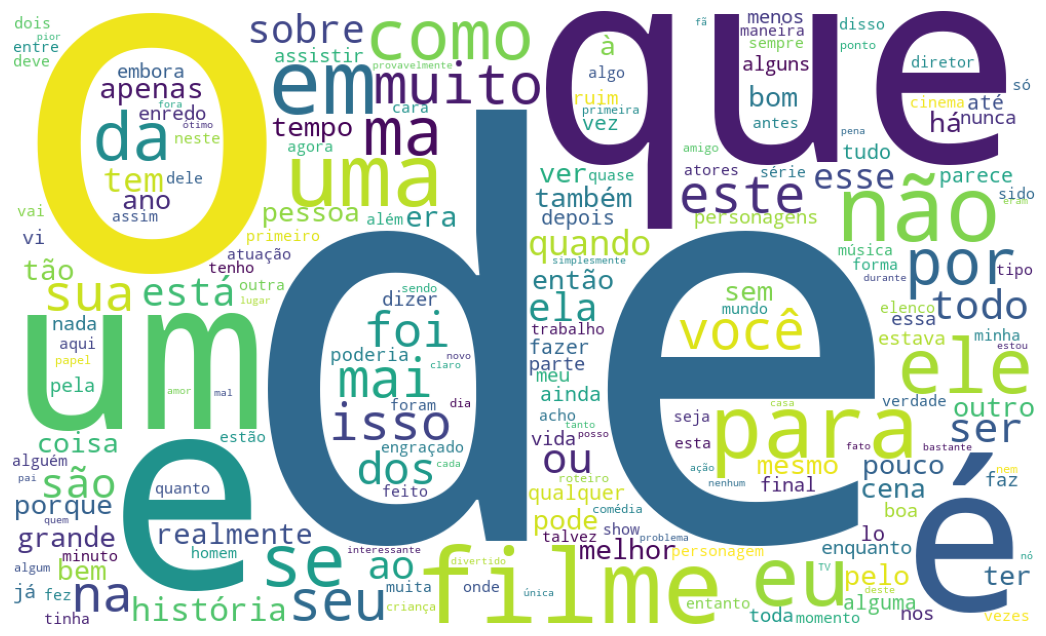

In [19]:
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Limpeza de caracter especial

In [20]:
import string
import pyspark.sql.functions as f

In [21]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["textos"])

In [23]:
# Usando regex para substituir um caracter especial por outro valor
amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))

In [24]:
amostra.show(truncate = False)

+------------------------------------------+------------------------------+
|textos                                    |texto_regex                   |
+------------------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |
|"bora *_* "                               |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]                            |
|ana@gmail.com                             |anagmailcom                   |
+------------------------------------------+------------------------------+



In [25]:
amostra = amostra.withColumn("texto_trim", f.trim("texto_regex"))

In [26]:
amostra.show(truncate = False)

+------------------------------------------+------------------------------+-----------------------------+
|textos                                    |texto_regex                   |texto_trim                   |
+------------------------------------------+------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |amovc pazamor                |
|"bora *_* "                               |bora                          |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |comprar arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]

In [27]:
# Fazendo o mesmo processo para o dataset original
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))
dados = dados.withColumn("texto_limpo", f.trim("texto_regex"))

## Tokenização

In [28]:
# Vamos tokenizar uma frase, onde cada token vai ser um palavra
from pyspark.ml.feature import Tokenizer
from pyspark.sql.types import IntegerType

In [29]:
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")

In [30]:
tokenizado = tokenizer.transform(dados)

In [31]:
tokenizado['texto_limpo', 'tokens'].show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [32]:
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())

tokenizado.select("texto_limpo", "tokens")\
.withColumn("feq_token", countTokens(f.col("tokens")))\
.show()

+--------------------+--------------------+---------+
|         texto_limpo|              tokens|feq_token|
+--------------------+--------------------+---------+
|Once again Mr Cos...|[once, again, mr,...|      168|
|This is an exampl...|[this, is, an, ex...|      232|
|First of all I ha...|[first, of, all, ...|      215|
|Not even the Beat...|[not, even, the, ...|      308|
|Brass pictures mo...|[brass, pictures,...|      238|
|A funny thing hap...|[a, funny, thing,...|      115|
|This German horro...|[this, german, ho...|      156|
|Being a longtime ...|[being, a, longti...|      136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|      129|
|Wealthy horse ran...|[wealthy, horse, ...|      160|
|Cage plays a drun...|[cage, plays, a, ...|      109|
|First of all I wo...|[first, of, all, ...|      333|
|So tell me  what ...|[so, tell, me, , ...|      243|
|A big disappointm...|[a, big, disappoi...|      110|
|This film is abso...|[this, film, is, ...|      185|
|Heres a decidedly...|[heres

## StopWords

In [33]:
# Remoção de ruídos
# Exemplo
data = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
                (0, 'Spark MLlib não ajuda muito'),
                (1, 'O MLlib do Spark ajuda e é fácil')]

colNames =['label', 'texto_limpo']
df = spark.createDataFrame(data, colNames)

In [34]:
# Usando NLTK
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Henry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
stop_A = stopwords.words("portuguese")

In [36]:
stop_A

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [37]:
# Usando PySpark
from pyspark.ml.feature import StopWordsRemover
stop_b = StopWordsRemover.loadDefaultStopWords("portuguese")

In [38]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol= "texto_limpo", outputCol="tokens")
tokenized = tokenizer.transform(df)

In [39]:
remover = StopWordsRemover(inputCol='tokens', outputCol='tokens')
tokenized = tokenizer.transform(df)

In [40]:
remover = StopWordsRemover(inputCol= "tokens", outputCol="texto_final", stopWords= stop_b)
df = remover.transform(tokenized)

In [41]:
df.show(truncate = False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [42]:
# Com dataset Original
remover = StopWordsRemover(inputCol= 'tokens', outputCol='texto_final')
feature_data = remover.transform(tokenizado)

In [43]:
feature_data.toPandas()

,id,text_en,text_pt,sentiment,texto_regex,texto_limpo,tokens,texto_final
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,Once again Mr Costner has dragged out a movie ...,Once again Mr Costner has dragged out a movie ...,"[once, again, mr, costner, has, dragged, out, ...","[mr, costner, dragged, movie, far, longer, nec..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,This is an example of why the majority of acti...,This is an example of why the majority of acti...,"[this, is, an, example, of, why, the, majority...","[example, majority, action, films, generic, bo..."
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,First of all I hate those moronic rappers who ...,First of all I hate those moronic rappers who ...,"[first, of, all, i, hate, those, moronic, rapp...","[first, hate, moronic, rappers, couldnt, act, ..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,Not even the Beatles could write songs everyon...,Not even the Beatles could write songs everyon...,"[not, even, the, beatles, could, write, songs,...","[even, beatles, write, songs, everyone, liked,..."
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,Brass pictures movies is not a fitting word fo...,Brass pictures movies is not a fitting word fo...,"[brass, pictures, movies, is, not, a, fitting,...","[brass, pictures, movies, fitting, word, reall..."
...,...,...,...,...,...,...,...,...
49454,49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos,Seeing as the vote average was pretty low and ...,Seeing as the vote average was pretty low and ...,"[seeing, as, the, vote, average, was, pretty, ...","[seeing, vote, average, pretty, low, fact, cle..."
49455,49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos,The plot had some wretched unbelievable twists...,The plot had some wretched unbelievable twists...,"[the, plot, had, some, wretched, unbelievable,...","[plot, wretched, unbelievable, twists, however..."
49456,49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos,I am amazed at how this movieand most others h...,I am amazed at how this movieand most others h...,"[i, am, amazed, at, how, this, movieand, most,...","[amazed, movieand, others, average, 5, stars, ..."
49457,49459,A Christmas Together actually came before my t...,A Christmas Together realmente veio antes do m...,pos,A Christmas Together actually came before my t...,A Christmas Together actually came before my t...,"[a, christmas, together, actually, came, befor...","[christmas, together, actually, came, time, iv..."


In [44]:
# Contagem de token antes e depois do stopwords
feature_data.select("tokens", "texto_final")\
                    .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
                    .withColumn("Fre_tokens_limpos", countTokens(f.col("texto_final"))).show()

+--------------------+--------------------+-----------+-----------------+
|              tokens|         texto_final|Freq_tokens|Fre_tokens_limpos|
+--------------------+--------------------+-----------+-----------------+
|[once, again, mr,...|[mr, costner, dra...|        168|               73|
|[this, is, an, ex...|[example, majorit...|        232|              131|
|[first, of, all, ...|[first, hate, mor...|        215|              111|
|[not, even, the, ...|[even, beatles, w...|        308|              169|
|[brass, pictures,...|[brass, pictures,...|        238|              140|
|[a, funny, thing,...|[funny, thing, ha...|        115|               52|
|[this, german, ho...|[german, horror, ...|        156|               74|
|[being, a, longti...|[longtime, fan, j...|        136|               73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|               75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|               99|
|[cage, plays, a, ...|[cage, plays, dr

## Bag of Word

###### Bag of Word (BoW) ele contabiliza as palavras que mais aparece, no PySpark usamos o CountVectorizer

In [45]:
from pyspark.ml.feature import CountVectorizer

In [46]:
cv = CountVectorizer(inputCol='texto_final', outputCol='CountVec')

In [47]:
model = cv.fit(df)

In [48]:
df = model.transform(df)

In [49]:
df.select('texto_final', 'countvec').show()

+--------------------+--------------------+
|         texto_final|            countvec|
+--------------------+--------------------+
|[spark, é, ótimo,...|(7,[0,1,4,5,6],[2...|
|[spark, mllib, aj...|(7,[0,2,3],[1.0,1...|
|[mllib, spark, aj...|(7,[0,1,2,3,4],[1...|
+--------------------+--------------------+



In [50]:
model.vocabulary

['spark', 'é', 'ajuda', 'mllib', 'fácil', 'nlp', 'ótimo']

In [51]:
# Aplicando no dataset original

In [52]:
cv = CountVectorizer(inputCol='texto_final', outputCol='CountVec')

In [53]:
model = cv.fit(feature_data)

In [54]:
countVectorizer_features = model.transform(feature_data)

In [56]:
countVectorizer_features.select('texto_final', 'CountVec').limit(5).show()

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(216710,[0,7,8,11...|
|[example, majorit...|(216710,[1,2,3,8,...|
|[first, hate, mor...|(216710,[0,2,4,11...|
|[even, beatles, w...|(216710,[0,1,2,4,...|
|[brass, pictures,...|(216710,[1,3,5,8,...|
+--------------------+--------------------+



## Hashing TF

###### Uma outra alternativa é o Hashign TF, é gerado uma mesma estrutura, entretando aqui limitamos o número de palavras contabilizadas

In [57]:
from pyspark.ml.feature import HashingTF

In [58]:
hashingTF = HashingTF(inputCol='texto_final', outputCol='hashingTF')

In [59]:
hashingTF.setNumFeatures(50)

HashingTF_c9abb217d3fd

In [60]:
HTFfeaturizeData = hashingTF.transform(countVectorizer_features)

In [61]:
HTFfeaturizeData.select("texto_final", "hashingTF").show(5)

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+
only showing top 5 rows



## TF-IDF

######  é uma medida estatística que visa indicar a importância de uma palavra em relação ao conjunto. É frequentemente utilizado como fator de ponderação na recuperação de informações e na mineração de dados. Em suma, este processo atribuirá um peso para cada uma das palavras.

In [62]:
from pyspark.ml.feature import IDF

In [63]:
idf = IDF(inputCol='hashingTF', outputCol='features')

In [64]:
idfModel = idf.fit(HTFfeaturizeData)

In [65]:
 TFIDFfeaturizeData = idfModel.transform(HTFfeaturizeData)

In [68]:
TFIDFfeaturizeData.select('texto_final', 'features').show(5)

+--------------------+--------------------+
|         texto_final|            features|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+
only showing top 5 rows



## Pipeline de Transformação

In [ ]:
## Precisamos fazer o tratamento da ultima coluna "sentiment"

In [69]:
TFIDFfeaturizeData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      neg|24765|
|      pos|24694|
+---------+-----+



In [70]:
from pyspark.ml.feature import StringIndexer

In [71]:
stringindexer = StringIndexer(inputCol='sentiment', outputCol='label')

In [72]:
dados = stringindexer.fit(dados).transform(dados)

In [73]:
dados.groupBy(['sentiment', 'label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      neg|  0.0|24765|
|      pos|  1.0|24694|
+---------+-----+-----+



## Unindo nossas transformações

In [74]:
from pyspark.ml import Pipeline

In [76]:
tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")

stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")

hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

tfidf = IDF(inputCol="HTF", outputCol="features")

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])

In [77]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [79]:
dados_transformados.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

# Treinando Modelo

# Decision Tree

In [83]:
featureDF = dados_transformados.select('features', 'label')

In [86]:
featureDF.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1000,[10,21,34,4...|  0.0|
|(1000,[0,3,11,12,...|  0.0|
|(1000,[1,7,33,38,...|  0.0|
|(1000,[0,3,10,12,...|  0.0|
|(1000,[3,6,7,11,3...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [85]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [87]:
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dtc = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, dtc])

## Criando dados de Treino e Teste

In [88]:
treino, teste = dados.randomSplit([0.7, 0.3], seed=101)

In [89]:
dtc_model = pipeline.fit(treino)

In [90]:
predictions = dtc_model.transform(teste)

In [100]:
predictions.select('label', 'prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



# Métricas

In [102]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [103]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

In [104]:
accuracy = evaluator.evaluate(predictions)

In [108]:
print(f'Accuracy: {round(accuracy,2)}')

Accuracy: 0.67


In [118]:
nova_base = spark.createDataFrame([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
        (0, "I loved the movie, excellent acting!"),
        (2, 'The movie is awesome !')
    ], ["id", "texto_limpo"])

In [119]:
nova_classe = dtc_model.transform(nova_base)

In [120]:
nova_classe.toPandas()

,id,texto_limpo,tokens,texto_final,HTF,features,rawPrediction,probability,prediction
0,1,This is without doubt the worst movie i have e...,"[this, is, without, doubt, the, worst, movie, ...","[without, doubt, worst, movie, ever, seen,, ha...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[727.0, 126.0]","[0.8522860492379836, 0.1477139507620164]",0.0
1,0,"I loved the movie, excellent acting!","[i, loved, the, movie,, excellent, acting!]","[loved, movie,, excellent, acting!]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[183.0, 672.0]","[0.21403508771929824, 0.7859649122807018]",1.0
2,2,The movie is awesome !,"[the, movie, is, awesome, !]","[movie, awesome, !]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3589.0, 4629.0]","[0.43672426381114626, 0.5632757361888537]",1.0
